## **Importing Libraries**

In [ ]:
!sudo apt update
!sudo apt install xvfb
!pip install gym
!pip3 install box2d-py
!apt-get install python-opengl -y
!apt install xvfb -y
!pip install pyvirtualdisplay
!pip install piglet
!pip install ma-gym

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Ign:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:7 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:8 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:13 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:15 http://archive.ubuntu.com/ubu

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from google.colab import widgets
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40)
import time
import random
import itertools
from collections import defaultdict
from matplotlib.pyplot import *

import os
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

import math
import glob
import io
import base64
from IPython.display import HTML
from IPython.display import clear_output
from IPython import display as ipythondisplay
import PIL

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision.transforms as T

from collections import namedtuple
from tqdm import tqdm
import time 
from google.colab import widgets

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## **Environment**

In [ ]:
class DetEnvironment(gym.Env):
    metadata = {'render.modes': []}
    
    def __init__(self,Dual_of_Agent = False):
        self.observation_space = spaces.Discrete(49) # 7*7 Grid
        self.action_space = spaces.Discrete(4) # {Right, Left, Up, Down}
        self.max_timesteps = 50
        self.Dual_of_Agent = Dual_of_Agent 
        
    def reset(self):
        # Setting Positions
        self.agent_pos1 = [0, 0]
        self.agent_pos2 = [0, 6]
        self.goal_pos = [6, 3]
        self.fruit_pos1 = [1, 4]
        self.fruit_pos2 = [4, 3]
        self.pit_pos1 = [2, 2]
        self.pit_pos2 = [2, 5]
        self.pit_pos3 = [4, 2]
        self.pit_pos4 = [4, 5]

        self.fruit_one_nottaken = True
        self.fruit_two_nottaken = True

        # Setting Rewards
        self.positive_reward = 1
        self.negative_reward = -1
        self.neutral_reward = 0
        self.goal_reward = 10
        self.fruit_reward = 3
        self.pit_reward = -5

        # Setting State Values
        self.state = np.zeros((7, 7))
        self.state[tuple(self.agent_pos1)] = 2.5
        self.state[tuple(self.agent_pos2)] = 2.5

        self.state[tuple(self.fruit_pos1)] = 0.5
        self.state[tuple(self.fruit_pos2)] = 0.5

        self.state[tuple(self.pit_pos1)] = 1
        self.state[tuple(self.pit_pos2)] = 1
        self.state[tuple(self.pit_pos3)] = 1
        self.state[tuple(self.pit_pos4)] = 1
        self.timestep_agentOne = 0
        self.timestep_agentTwo = 0
        self.state[tuple(self.goal_pos)] = 2

        observation1 = self.agent_pos1
        observation2 = self.agent_pos2

        if self.Dual_of_Agent == False:
          return observation1, observation2
        else:
          return observation1
    
    def step_agent1(self, action,max_timesteps = None, timestep = None):
        
        if (max_timesteps == None or timestep == None):
            max_timesteps = self.max_timesteps
            timestep = self.timestep_agentOne
          
        agent_old_pos = self.agent_pos1.copy()

        if action == 0:
            self.agent_pos1[0] += 1
        # up
        if action == 1:
            self.agent_pos1[0] -= 1
        # left
        if action == 2:
            self.agent_pos1[1] += 1
        # right
        if action == 3:
            self.agent_pos1[1] -= 1
          
        # Safty Measure - Making sure the Agent is inside the grid
        self.agent_pos1 = np.clip(self.agent_pos1, 0, 6)

        observation = self.agent_pos1
        reward = 0

        # Reward Allocation for different States 
        if (self.agent_pos1 == self.goal_pos).all():
          reward += self.goal_reward
        elif (self.agent_pos1 == self.fruit_pos1).all() and self.fruit_one_nottaken:
          reward += self.fruit_reward
          self.fruit_one_nottaken = False
        elif (self.agent_pos1 == self.fruit_pos2).all() and self.fruit_two_nottaken:
          reward += self.fruit_reward
          self.fruit_two_nottaken = False
        elif (self.agent_pos1 == self.pit_pos1).all():
          reward += self.pit_reward
        elif (self.agent_pos1 == self.pit_pos2).all():
          reward += self.pit_reward
        elif (self.agent_pos1 == self.pit_pos3).all():
          reward += self.pit_reward
        elif (self.agent_pos1 == self.pit_pos4).all():
          reward += self.pit_reward
        
        x1 = agent_old_pos[1]
        y1 = agent_old_pos[0]

        x2 = self.goal_pos[1]
        y2 = self.goal_pos[0]
#distance of old postion from the goal
        olddistance = abs(x1 - x2) + abs(y1 - y2)

        x1 = self.agent_pos1[1]
        y1 = self.agent_pos1[0]
        newdistance = abs(x1 - x2) + abs(y1 - y2)

        if newdistance < olddistance:
            reward += self.positive_reward
        else:
            reward += self.negative_reward

        # Stopping Criterion
        if timestep >= max_timesteps or (self.agent_pos1 == self.goal_pos).all():
          done = True 
        else:
          done = False

        if (self.agent_pos1 == self.goal_pos).all():
          goal_reached = True
        else:
          goal_reached = False

        info = {"goal_reached": goal_reached}
        
        self.timestep_agentOne +=1
        return observation, reward, done,goal_reached ,info

    def step_agent2(self, action, max_timesteps = None, timestep = None):
        # Deterministic Actions

        if (max_timesteps == None or timestep == None):
            max_timesteps = self.max_timesteps
            timestep = self.timestep_agentTwo

        agent_old_pos = self.agent_pos2.copy()

        if action == 0:
            self.agent_pos2[0] += 1
        # up
        if action == 1:
            self.agent_pos2[0] -= 1
        # left
        if action == 2:
            self.agent_pos2[1] += 1
        # right
        if action == 3:
            self.agent_pos2[1] -= 1
        
        # Safty Measure - Making sure the Agent is inside the grid
        self.agent_pos2 = np.clip(self.agent_pos2, 0, 6)

        observation = self.agent_pos2

        reward = 0  
        # Reward Allocation for different States 
        if (self.agent_pos2 == self.goal_pos).all():
          reward += self.goal_reward
        elif (self.agent_pos2 == self.fruit_pos1).all() and self.fruit_one_nottaken:
          reward += self.fruit_reward
          self.fruit_one_nottaken = False
        elif (self.agent_pos2 == self.fruit_pos2).all() and self.fruit_two_nottaken:
          reward += self.fruit_reward
          self.fruit_two_nottaken = False
        elif (self.agent_pos2 == self.pit_pos1).all():
          reward += self.pit_reward
        elif (self.agent_pos2 == self.pit_pos2).all():
          reward += self.pit_reward
        elif (self.agent_pos2 == self.pit_pos3).all():
          reward += self.pit_reward
        elif (self.agent_pos2 == self.pit_pos4).all():
          reward += self.pit_reward
                
        # Stopping Criterion
        if timestep >= max_timesteps or (self.agent_pos2 == self.goal_pos).all():
          done = True 
        else:
          done = False

        if (self.agent_pos2 == self.goal_pos).all():
          goal_reached = True
        else:
          goal_reached = False

        
        x1 = agent_old_pos[1]
        y1 = agent_old_pos[0]

        x2 = self.goal_pos[1]
        y2 = self.goal_pos[0]
      #distance of old postion from the goal
        olddistance = abs(x1 - x2) + abs(y1 - y2)

        x1 = self.agent_pos1[1]
        y1 = self.agent_pos1[0]
        newdistance = abs(x1 - x2) + abs(y1 - y2)

        if newdistance < olddistance:
            reward += self.positive_reward
        else:
            reward += self.negative_reward

        self.timestep_agentTwo +=1

        info = {}
        
        return observation, reward, done, goal_reached, info
        
    def render(self):
        # Displaying the State
        plt.imshow(self.state)

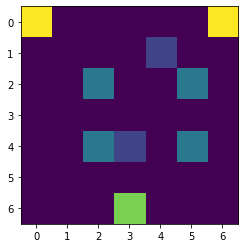

In [ ]:
env = DetEnvironment()
env.reset()
env.render()

## **Agent Interaction function**

In [ ]:
def learn_policy(teacher_agent_state=None, learner_agent_state=None, teacher_reward=None, learner_action_list=None):
  '''
  This function learns the policy of an agent to guide the other agent
  '''
  if teacher_reward > 0:
    row_diff = teacher_agent_state[0]-learner_agent_state[0]
    col_diff = teacher_agent_state[1]-learner_agent_state[1]

    if row_diff > 0:
      learner_action_list.append(0)
    elif row_diff < 0:
      learner_action_list.append(1)
    else:
      if col_diff > 0:
        learner_action_list = learner_action_list + [0, 1, 2]
      else:
        learner_action_list = learner_action_list + [0, 1, 3]

    if col_diff > 0:
      learner_action_list.append(2)
    if col_diff < 0:
      learner_action_list.append(3)
    else:
      if row_diff > 0:
        learner_action_list = learner_action_list + [0, 2, 3]
      else:
        learner_action_list = learner_action_list + [1, 2, 3]

  elif teacher_reward < 0:
    row_diff = teacher_agent_state[0]-learner_agent_state[0]
    col_diff = teacher_agent_state[1]-learner_agent_state[1]

    if row_diff > 0:
      learner_action_list.append(1)
    if row_diff < 0:
      learner_action_list.append(0)
    else:
      if col_diff > 0:
        learner_action_list = learner_action_list + [0, 1, 3]
      else:
        learner_action_list = learner_action_list + [0, 1, 2]

    if col_diff > 0:
      learner_action_list.append(3)
    if col_diff < 0:
      learner_action_list.append(2)
    else:
      if row_diff > 0:
        learner_action_list = learner_action_list + [1, 2, 3]
      else:
        learner_action_list = learner_action_list + [0, 2, 3]
  else:
    learner_action_list = [0, 1, 2, 3]

  return learner_action_list

## **Q-Learning Functions**

In [ ]:
def select_policy(epsilon, number_of_actions, q_dict, state):
  '''
  This function chooses an action based on the value of greedyness
  '''
  prob_ = random.uniform(0, 1)
  if prob_ < epsilon:
    action_index = random.choice(number_of_actions)
  else:
    action_index = np.argmax(q_dict[str(state)])

  return action_index


def q_learning(episodes, env, epsilon, learning_rate, discount_factor, max_timesteps):
  '''
  This is the function for Single-Agent Q-Learning
  '''

  # Initializing Q values
  q_dict_agent1 = defaultdict(lambda: np.zeros(env.action_space.n))

  reward_per_ep_list = list()

  epsilon_list = list() # List to store epsilon values for all episodes
  epsilon_list.append(epsilon)

  timesteps_list = list() # List o store timestepst values for all episodes

  for ep_ in range(episodes):
    state_agent1, _ = env.reset() # Resetting the Env.
    timestep = 0 
    done = False

    reward_per_ep = 0 # Initial Value for Reward per Episode

    actions_list_agent1 = [0, 1, 2, 3]

    while not done:
      # Choose an action
      action_agent1 = select_policy(epsilon, actions_list_agent1, q_dict_agent1, state_agent1)

      timestep = timestep + 1

      # Perform the action -> Obtain a new state -> Get a new reward
      next_state_agent1, reward_agent1, done_agent1, is_goal_reached_agent1, info_agent1 = env.step_agent1(action_agent1, max_timesteps, timestep)

      if done_agent1:
        done = True
      
      state_agent1 = np.clip(state_agent1, 0, 6)
      next_state_agent1 = np.clip(next_state_agent1, 0, 6)

      # ----------------- Q-Learning updates ------------------
      loss = reward_agent1 + (discount_factor*max(q_dict_agent1[str(next_state_agent1)])) - q_dict_agent1[str(state_agent1)][action_agent1]
      q_dict_agent1[str(state_agent1)][action_agent1] = q_dict_agent1[str(state_agent1)][action_agent1] + learning_rate*loss
      
      state_agent1 = next_state_agent1
      reward_per_ep = reward_per_ep + reward_agent1

    reward_per_ep_list.append(reward_per_ep)

    epsilon = epsilon*np.exp(-0.005)
    epsilon_list.append(epsilon)

    timesteps_list.append(timestep)
  
  # ------------------------ Plot : Reward per Episode ---------------------------
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_list)+1)), reward_per_ep_list, color='r')
  xlabel('Episodes')
  ylabel('Reward per Episode')
  title('Reward per Episode by single Agent')

  # ------------------------ Plot : Cumulative Rewards ---------------------------
  # Both Agents
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_list)+1)), list(np.cumsum(reward_per_ep_list)), color='b')
  xlabel('Episodes')
  ylabel('Cumulative Reward')
  title('Cumulative Reward by single Agent')

  # ----------------- Plot : Episodes v/s Timesteps used -------------------
  figure(figsize=(10, 6))
  plot(list(range(1, len(timesteps_list)+1)), timesteps_list, color='g')
  xlabel('Episodes')
  ylabel('Timesteps Taken')
  title('Timesteps Taken to Reach the Goal - Single Agent')

  # ------------------ Plot : Epsilon decay -------------------
  figure(figsize=(10, 6))
  plot(list(range(1, len(epsilon_list)+1)), epsilon_list, color='g')
  xlabel('Episodes')
  ylabel('Epsilon')
  title('Epsilon Decay')

  return reward_per_ep_list, timesteps_list, epsilon_list


def q_learning_marl(episodes, env, epsilon, learning_rate, discount_factor, max_timesteps):
  '''
  This is the function for Multi-Agent Q-Learning
  '''

  # Initializing Q values
  q_dict_agent1 = defaultdict(lambda: np.zeros(env.action_space.n))
  q_dict_agent2 = defaultdict(lambda: np.zeros(env.action_space.n))

  reward_per_ep_list = list()
  reward_per_ep_agent1_list = list()
  reward_per_ep_agent2_list = list()

  epsilon_list = list() # List to store epsilon values for all episodes
  epsilon_list.append(epsilon)

  timesteps_list = list() # List to store timesteps values for all episodes

  for ep_ in range(episodes):
    state_agent1, state_agent2 = env.reset() # Resetting the Env.
    timestep = 0 
    done = False

    reward_per_ep = 0 # Initial Value for Reward per Episode
    reward_per_ep_agent1 = 0 # Initial Value for Reward per Episode - Agent 1
    reward_per_ep_agent2 = 0 # Initial Value for Reward per Episode - Agent 2

    actions_list_agent1 = [0, 1, 2, 3]
    actions_list_agent2 = [0, 1, 2, 3]

    while not done:
      # Choose an action
      action_agent1 = select_policy(epsilon, actions_list_agent1, q_dict_agent1, state_agent1)
      action_agent2 = select_policy(epsilon, actions_list_agent2, q_dict_agent2, state_agent2)

      timestep = timestep + 1

      # Perform the action -> Obtain a new state -> Get a new reward
      next_state_agent1, reward_agent1, done_agent1, is_goal_reached_agent1, info_agent1 = env.step_agent1(action_agent1, max_timesteps, timestep)
      next_state_agent2, reward_agent2, done_agent2, is_goal_reached_agent2, info_agent2 = env.step_agent2(action_agent2, max_timesteps, timestep)

      if done_agent1 or done_agent2:
        done = True
      
      state_agent1 = np.clip(state_agent1, 0, 6)
      state_agent2 = np.clip(state_agent2, 0, 6)

      next_state_agent1 = np.clip(next_state_agent1, 0, 6)
      next_state_agent2 = np.clip(next_state_agent2, 0, 6)

      # ----------------- Q-Learning updates ------------------
      # Agent 1
      loss = reward_agent1 + (discount_factor*max(q_dict_agent1[str(next_state_agent1)])) - q_dict_agent1[str(state_agent1)][action_agent1]
      q_dict_agent1[str(state_agent1)][action_agent1] = q_dict_agent1[str(state_agent1)][action_agent1] + learning_rate*loss

      # Agent 2
      loss = reward_agent2 + (discount_factor*max(q_dict_agent2[str(next_state_agent2)])) - q_dict_agent2[str(state_agent2)][action_agent2]
      q_dict_agent2[str(state_agent2)][action_agent2] = q_dict_agent2[str(state_agent2)][action_agent2] + learning_rate*loss

      # -------------------- Interaction between Agents -----------------------
      actions_list_agent1 = list()
      actions_list_agent2 = list()

      actions_list_agent1 = learn_policy(teacher_agent_state=next_state_agent2, learner_agent_state=next_state_agent1, teacher_reward=reward_agent2,
                                          learner_action_list=actions_list_agent1)
      actions_list_agent2 = learn_policy(teacher_agent_state=next_state_agent1, learner_agent_state=next_state_agent2, teacher_reward=reward_agent1,
                                          learner_action_list=actions_list_agent2)

      assert actions_list_agent1, 'Empty list found for Agent 1!'
      assert actions_list_agent2, 'Empty list found for Agent 2!'

      actions_list_agent1 = list(set(actions_list_agent1))
      actions_list_agent2 = list(set(actions_list_agent2))
      
      state_agent1 = next_state_agent1
      state_agent2 = next_state_agent2

      reward_per_ep = reward_per_ep + (reward_agent1+reward_agent2)/2
      reward_per_ep_agent1 = reward_per_ep_agent1 + reward_agent1
      reward_per_ep_agent2 = reward_per_ep_agent2 + reward_agent2

    reward_per_ep_list.append(reward_per_ep)
    reward_per_ep_agent1_list.append(reward_per_ep_agent1)
    reward_per_ep_agent2_list.append(reward_per_ep_agent2)

    epsilon = epsilon*np.exp(-0.005)
    epsilon_list.append(epsilon)

    timesteps_list.append(timestep)

#------------------------------------------------Eval
  reward_per_ep_agent1_list_eval = []
  reward_per_ep_agent2_list_eval = []
  reward_per_ep_average_bothagent_list_eval = []



  epsilon = 0
  for ep_ in range(0,10):
    state_agent1, state_agent2 = env.reset() # Resetting the Env.
    timestep = 0 
    done = False

    reward_per_ep = 0 # Initial Value for Reward per Episode
    reward_per_ep_agent1 = 0 # Initial Value for Reward per Episode - Agent 1
    reward_per_ep_agent2 = 0 # Initial Value for Reward per Episode - Agent 2

    actions_list_agent1 = [0, 1, 2, 3]
    actions_list_agent2 = [0, 1, 2, 3]

    score_agent1 = 0
    score_agent2 = 0
    while not done:
      # Choose an action
      action_agent1 = select_policy(epsilon, actions_list_agent1, q_dict_agent1, state_agent1)
      action_agent2 = select_policy(epsilon, actions_list_agent2, q_dict_agent2, state_agent2)
    
      next_state_agent1, reward_agent1, done_agent1, is_goal_reached_agent1, info_agent1 = env.step_agent1(action_agent1, max_timesteps, timestep)
      next_state_agent2, reward_agent2, done_agent2, is_goal_reached_agent2, info_agent2 = env.step_agent2(action_agent2, max_timesteps, timestep)

      if done_agent1 or done_agent2:
        done = True
      
      state_agent1 = next_state_agent1
      state_agent2 = next_state_agent2

      score_agent1 += reward_agent1
      score_agent2 += reward_agent2
    
    reward_per_ep = reward_per_ep + (score_agent1+score_agent2)/2
    reward_per_ep_average_bothagent_list_eval.append(reward_per_ep)
    reward_per_ep_agent1_list_eval.append(score_agent1)
    reward_per_ep_agent2_list_eval.append(score_agent2)


    # ------------------------ Plots : Reward per Episode For Eval ---------------------------
  # Both Agents
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_agent1_list_eval)+1)), reward_per_ep_agent1_list_eval, color='r')
  xlabel('Episodes')
  ylabel('Reward per Episode')
  title('Reward Per Episode For Evalutation Agent 1')

    # Both Agents
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_agent2_list_eval)+1)), reward_per_ep_agent2_list_eval, color='r')
  xlabel('Episodes')
  ylabel('Reward per Episode')
  title('Reward Per Episode For Evalutation Agent 2')

  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_average_bothagent_list_eval)+1)), reward_per_ep_average_bothagent_list_eval, color='r')
  xlabel('Episodes')
  ylabel('Reward per Episode')
  title('Reward Per Episode For Evalutation For Both Agent')
    
  
  # ------------------------ Plots : Reward per Episode ---------------------------
  # Both Agents
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_list)+1)), reward_per_ep_list, color='r')
  xlabel('Episodes')
  ylabel('Average Reward per Episode')
  title('Average Reward per Episode by both Agents')
  
  # Agent 1
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_agent1_list)+1)), reward_per_ep_agent1_list, color='r')
  xlabel('Episodes')
  ylabel('Average Reward per Episode')
  title('Average Reward per Episode by Agent 1')
  
  # Agent 2
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_agent2_list)+1)), reward_per_ep_agent2_list, color='r')
  xlabel('Episodes')
  ylabel('Average Reward per Episode')
  title('Average Reward per Episode by Agent 2')

  # ------------------------ Plots : Cumulative Rewards ---------------------------
  # Both Agents
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_list)+1)), list(np.cumsum(reward_per_ep_list)), color='b')
  xlabel('Episodes')
  ylabel('Cumulative Reward')
  title('Cumulative Reward by both Agents')
  
  # Agent 1
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_agent1_list)+1)), list(np.cumsum(reward_per_ep_agent1_list)), color='b')
  xlabel('Episodes')
  ylabel('Cumulative Reward')
  title('Cumulative Reward by Agent 1')
  
  # Agent 2
  figure(figsize=(10, 6))
  plot(list(range(1, len(reward_per_ep_agent2_list)+1)), list(np.cumsum(reward_per_ep_agent2_list)), color='b')
  xlabel('Episodes')
  ylabel('Cumulative Reward')
  title('Cumulative Reward by Agent 2')

  # ----------------- Plot : Episodes v/s Timesteps used -------------------
  figure(figsize=(10, 6))
  plot(list(range(1, len(timesteps_list)+1)), timesteps_list, color='g')
  xlabel('Episodes')
  ylabel('Timesteps Taken')
  title('Timesteps Taken to Reach the Goal - Multi-Agent')

  # ------------------ Plot : Epsilon decay -------------------
  figure(figsize=(10, 6))
  plot(list(range(1, len(epsilon_list)+1)), epsilon_list, color='g')
  xlabel('Episodes')
  ylabel('Epsilon')
  title('Epsilon Decay')

  return reward_per_ep_list, reward_per_ep_agent1_list, reward_per_ep_agent2_list, timesteps_list, epsilon_list

## **Values taken**

In [ ]:
episodes = 2000
epsilon_start = 0.9
learning_rate = 0.001
discount_factor = 0.9
max_timesteps = 50

## **Q-Learning for Single Agent**

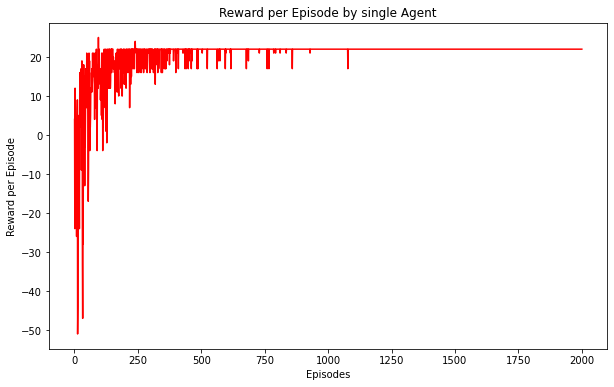

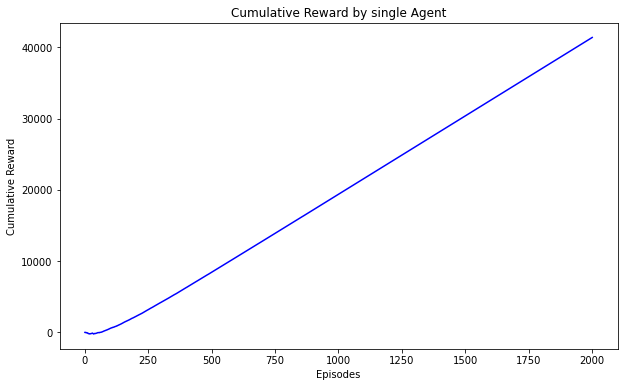

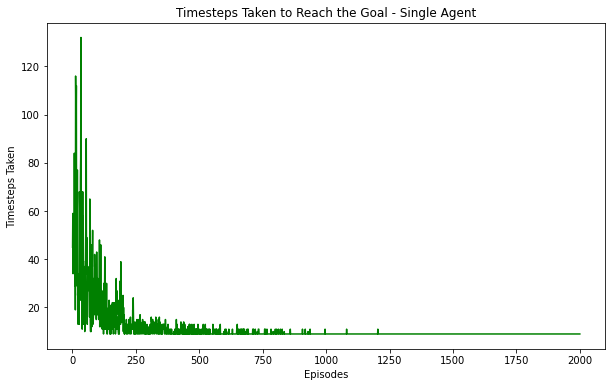

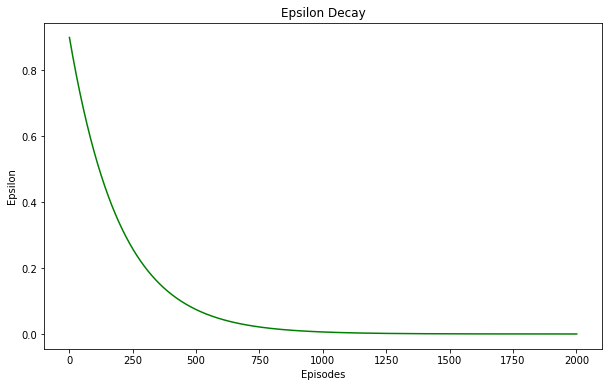

In [ ]:
env = DetEnvironment()
reward_per_ep_list, timesteps_list, epsilon_list = q_learning(episodes, env, epsilon_start, learning_rate, discount_factor, max_timesteps)

## **Q-Learning for Multi-Agent**

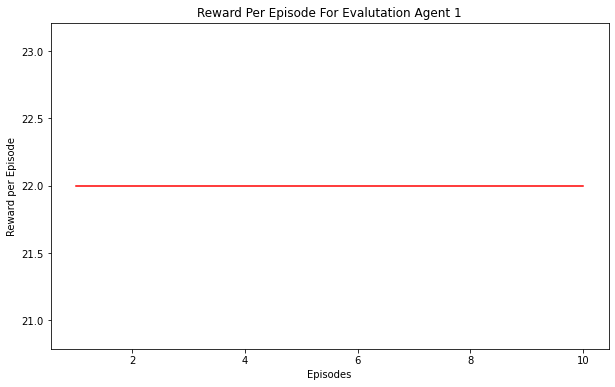

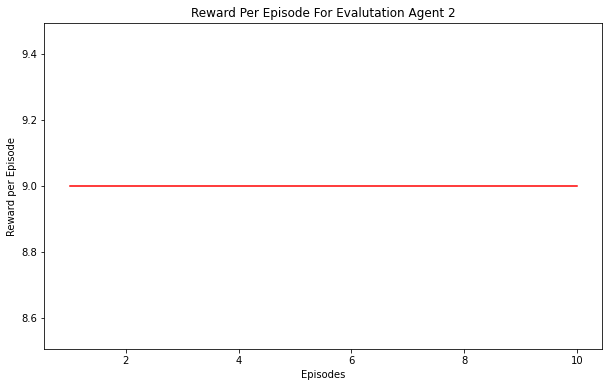

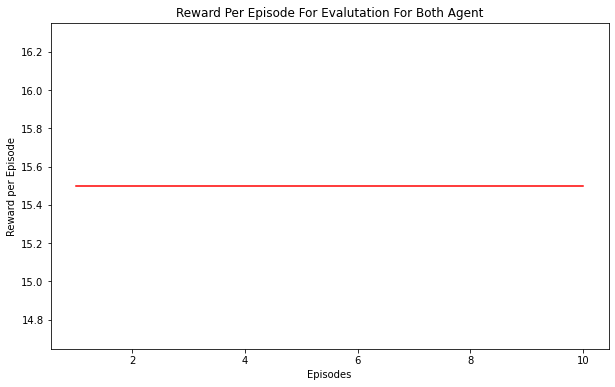

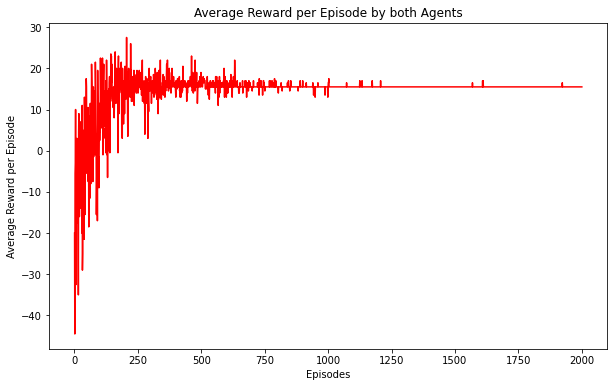

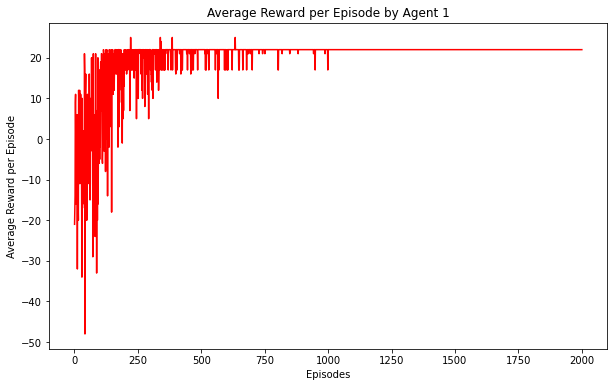

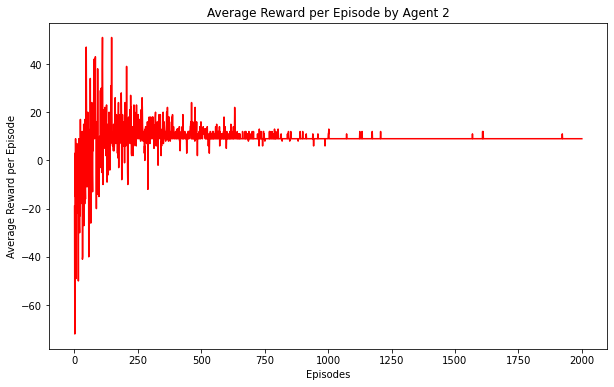

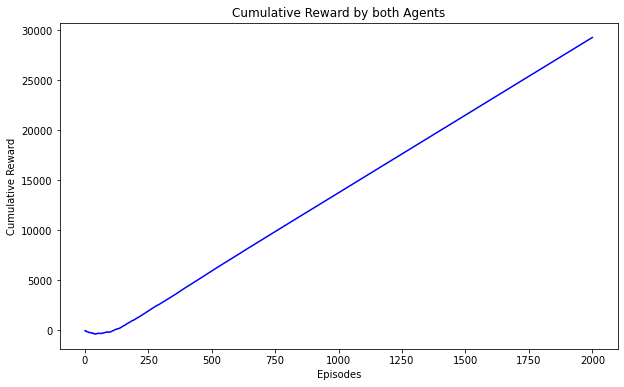

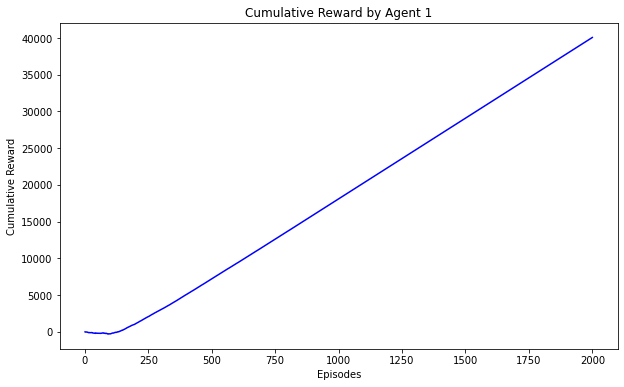

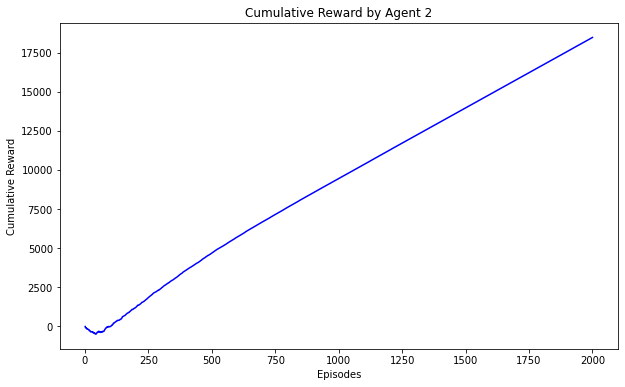

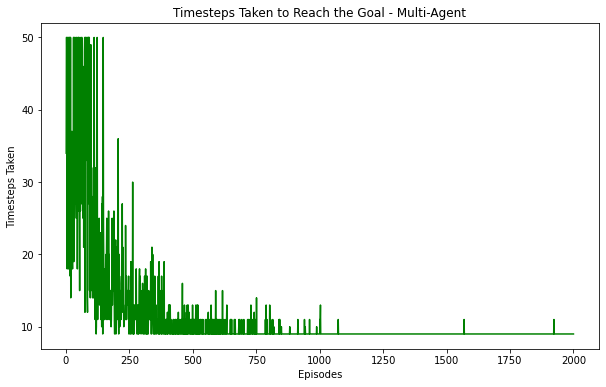

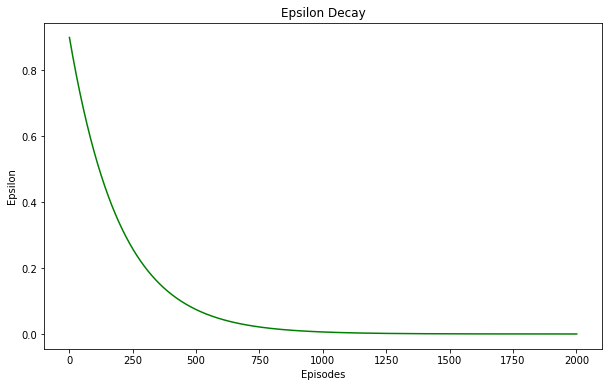

In [ ]:
env = DetEnvironment()
reward_per_ep_list, reward_per_ep_agent1_list, reward_per_ep_agent2_list, timesteps_list, epsilon_list = q_learning_marl(episodes, env, epsilon_start, learning_rate, discount_factor, max_timesteps)